 # Data Science Test - Rental Car Reservations

Nigel L. Mathes

## Pre-analysis steps

To begin analysis, I first need to import packages, prep the plotting environment, and read in the data. I choose to use python's Pandas dataframes to manage the two input files as database files.

In [24]:
import tensorflow as tf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('ggplot')
plt.rc('figure',figsize=(13,13))

# Make things look nicer
LABEL_SIZE = 18
LEGEND_SIZE = 12

plt.rc('lines', linewidth=1.75)

# Read in data to pandas dataframes
VEHICLE_DATA = pd.read_csv("vehicles.csv")
RESERVATION_DATA = pd.read_csv("reservations.csv")

I want to count the number of rentals per vehicle ID in reservations.csv, appending these values as a column in vehicles.csv, in order to compare vehicle properties to reservation numbers directly. I also expect that a key factor in customer decisions may be the price difference between the actual and recommended prices, so I create a new column for this parameter as well. Finally, I merge the two dataframes to facilitate easy histogram plotting and analysis using the reservations data as a basis.

In [25]:
# Count frequency of rentals and add column to VEHICLE_DATA
veh_id = VEHICLE_DATA.as_matrix(columns=['vehicle_id'])
res_id = RESERVATION_DATA.as_matrix(columns=['vehicle_id'])

# Use numpy here to ensure zero counts as a value
n_reservations = np.zeros(len(veh_id))
for i,id in enumerate(veh_id):
    n_reservations[i] = len(np.where(id == res_id)[0])
VEHICLE_DATA['num_reservations'] = n_reservations.astype(int)

# Add column with difference between the recommended price and the actual price
VEHICLE_DATA['diff_price'] = VEHICLE_DATA['recommended_price'] - VEHICLE_DATA['actual_price']

# Add a column that 'bucketizes' the number of reservations (low, med, high) categories
VEHICLE_DATA['categorical_reservations'] = pd.cut(VEHICLE_DATA['num_reservations'], 3, labels=["low","medium","high"])

# Merge databases to get vehicle features in the RESERVATION_DATA dataframe
MERGED_DATA = pd.merge(VEHICLE_DATA,RESERVATION_DATA)

In [26]:
# Define columns to plot initially as an exploration step
PLOT_COLUMNS = ['technology', 'num_images', 'street_parked', 'description','actual_price',
                'recommended_price','diff_price','num_reservations']

## Finding the most important factors driving the total number of reservations

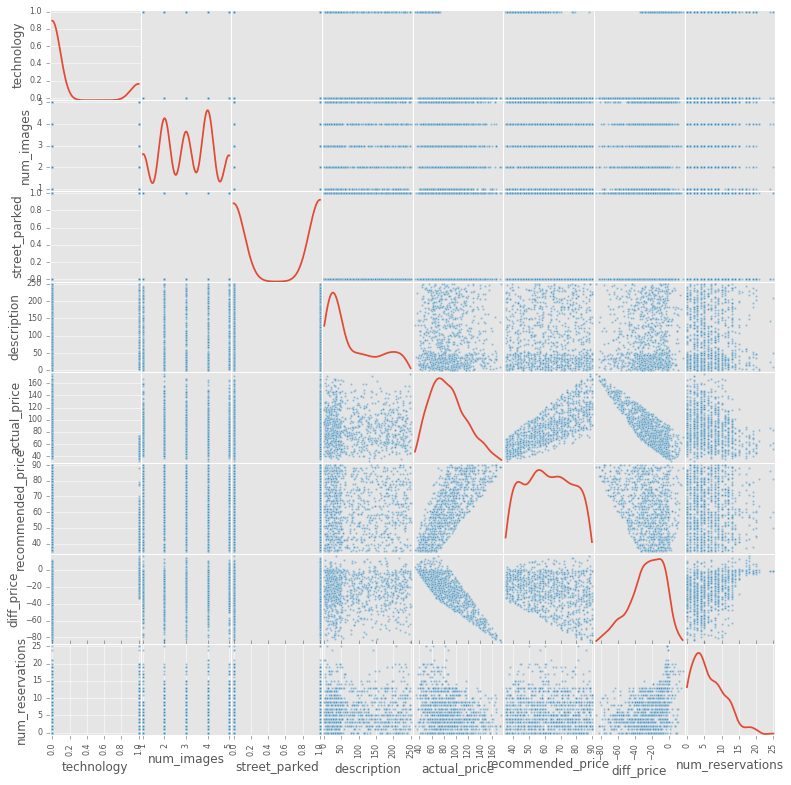

In [27]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(VEHICLE_DATA[PLOT_COLUMNS], diagonal='kde')
plt.show()

The plot above shows every measured parameter, along with the newly added price-difference and number-of-reservations parameters, plotted against one another. I used this to try to quickly determine, visually, what parameters might drive the number of reservations. This is probably at the limit, in terms of number of parameters, of what I would just throw onto a scatter plot to inspect. A few things pop out:
 * Actual price, recommended price, and the price difference are all correlated (unsurprisingly)
 * The recommended price distribution is relatively flat, and it may not play a major role in reservations
 * Discrete parameters are hard to interpret here, but don't seem to show trends
 
The next step is to look at the price trends more closely.

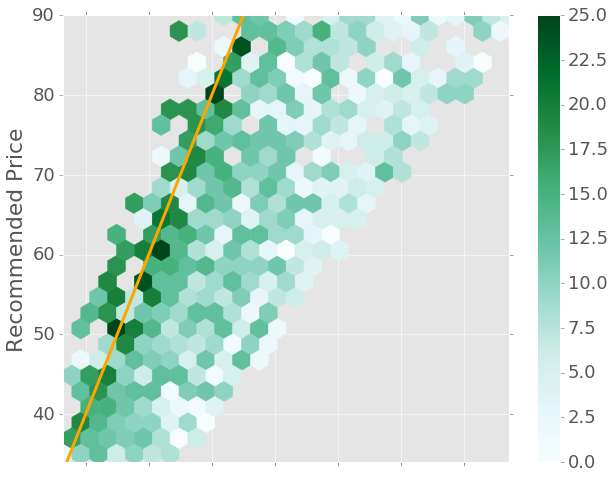

In [28]:
plt.rcParams.update({'font.size': LABEL_SIZE})
plt.rc('figure',figsize=(10,8))
VEHICLE_DATA.plot.hexbin(x='actual_price',y='recommended_price',C='num_reservations',reduce_C_function=np.max,
                         gridsize=25,figsize=(10,8))
plt.ylabel("Recommended Price")
plt.xlabel("Actual Price")
plt.plot([34,90],[34,90],color='orange',linewidth=3)
plt.show()

In the above figure, I show the recommended price versus the actual price in a hex density plot, with the color intensity representing the number of reservations. The orange line represents a one-to-one correlation between the two parameters. One can see immediately that there is a high density of reservations corresponding to the one-to-one line, where the actual price very nearly matches the recommended price. I also feel confident, now, that the recommended price does not need to be a free parameter in the future machine learning analysis, instead substituting the price difference. 

Buyers naturally want to reserve a car at a price they perceive as fair, and coming close to the recommended price is very important.

In [29]:
# Define feature columns to explore with machine learning
FEATURE_COLUMNS = ['technology', 'num_images', 'street_parked', 'description','diff_price','actual_price']

# Random forest regressor for continuous num_reservations
TARGET_COLUMN = ['num_reservations']
rf = RandomForestRegressor()
rf.fit(VEHICLE_DATA[FEATURE_COLUMNS],VEHICLE_DATA[TARGET_COLUMN].values.ravel())

print "====================================================================================="
print "Features Sorted by Score for Regressor:\n"
print sorted(zip(map(lambda x: round(x,4), rf.feature_importances_),FEATURE_COLUMNS),reverse=True)

# Random forest classifier for bucketized num_reservations
TARGET_COLUMN = ['categorical_reservations']
rf = RandomForestClassifier()
rf.fit(VEHICLE_DATA[FEATURE_COLUMNS],VEHICLE_DATA[TARGET_COLUMN].values.ravel())

print "\nFeatures Sorted by Score for Classifier:\n"
print sorted(zip(map(lambda x: round(x,4), rf.feature_importances_),FEATURE_COLUMNS),reverse=True)
print "====================================================================================="

Features Sorted by Score for Regressor:

[(0.4322, 'diff_price'), (0.2104, 'actual_price'), (0.2063, 'description'), (0.1065, 'num_images'), (0.029, 'street_parked'), (0.0156, 'technology')]

Features Sorted by Score for Classifier:

[(0.342, 'diff_price'), (0.2945, 'actual_price'), (0.2122, 'description'), (0.1057, 'num_images'), (0.0295, 'street_parked'), (0.0161, 'technology')]


In the above code, I explore the data set using a Random Forest algorithm. It is a relatively quick and exceptionally versatile way to examine labelled data and derive relationships. In this case, I am using it to "score" the various parameters by how much they contribute to the number of reservations. 

I ask the Random Forest algorithm first to classify based upon the raw number of reservations. I then also ask it to examine labels which are "bucketized," or binned, into three categories: low, medium, and high numbers of reservations, effectively smoothing out the options and ensuring that extreme values do not drive perceived trends.

**We can conclude that the difference between the actual price of the car and the recommend price of the car is exceptionally important, followed by the actual price of the car, and then followed by the number of characters in the car's description.** The number of images, whether or not it can be street parked, and the technology package do not play a large role in getting a car reserved frequently.

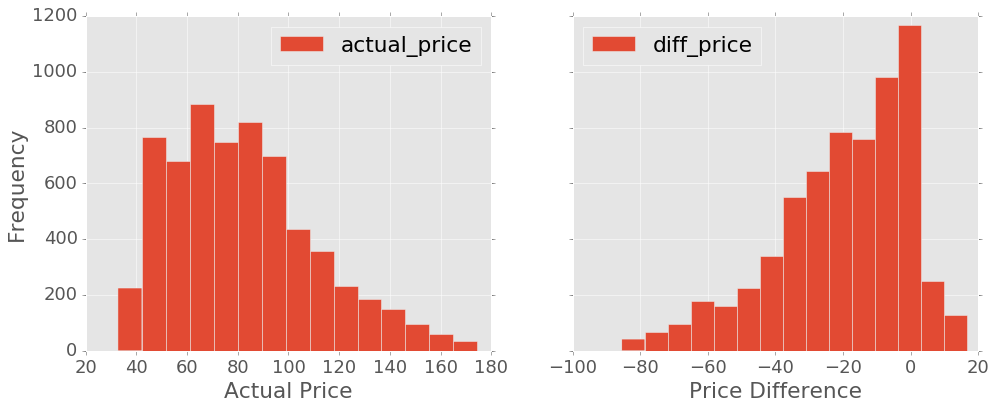

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(16)

MERGED_DATA[['actual_price']].plot.hist(bins=15,ax=axes[0])
axes[0].set_xlabel("Actual Price")
MERGED_DATA[['diff_price']].plot.hist(bins=15,ax=axes[1])
plt.xlabel("Price Difference")
plt.show()

In the above figures, I examine exactly how the price factors in to the number of reservations. These histograms show the number of reservations on the y-axis as a function of either the actual price or the difference between the actual price and the recommended price.

On the left, it appears that as price goes down, the number of reservations goes up, at least until roughly the $90 mark, where, below this level, the distribution flattens.

On the right, the trend is more pronounced. As the price approaches the recommended price, the number of reservations increases. 

**Lower prices lead to higher numbers of reservations, up until a point (near $90). At prices below this level, what matters most is how well the actual price matches the recommended price. Customers want to get a deal, and when they get that deal, they want it to be a fair deal.**

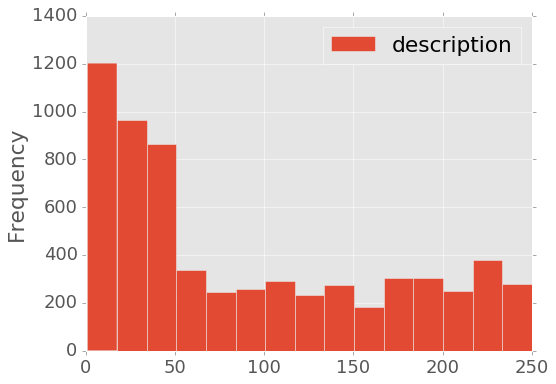

In [31]:
MERGED_DATA[['description']].plot.hist(bins=15,figsize=(8,6))
plt.show()

The final important parameter is the length of the description. The above plot shows the frequency of reservations as a function of the description character length. **I can quickly conclude that more reservations are made for cars with descriptions less than 50 characters.** After this point, the length of the description does not play a major role in one's decision whether or not to reserve a vehicle. 

## What role does the technology package play?

I already know that the presence of the technology package does not significantly influence the number of reservations. Knowing this, I want to explore whether it has a impact on the type of reservations made.

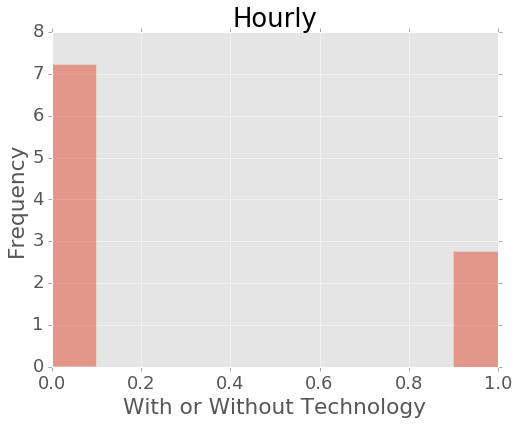

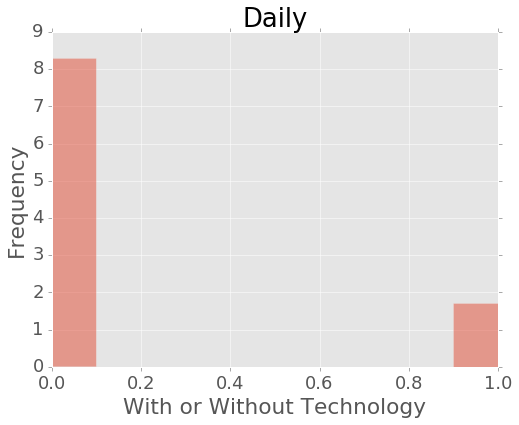

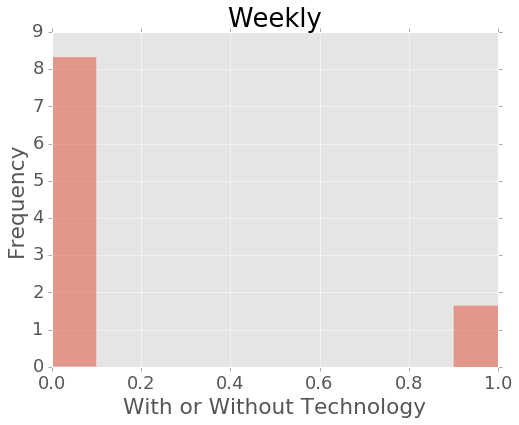

In [32]:
plt.rc('figure',figsize=(8,6))
plt.figure(1)
MERGED_DATA.loc[MERGED_DATA['reservation_type']==1]['technology'].plot.hist(alpha=0.5,title="Hourly",
                                                                            normed=True)
plt.xlabel("With or Without Technology")

plt.figure(2)
MERGED_DATA.loc[MERGED_DATA['reservation_type']==2]['technology'].plot.hist(alpha=0.5,title="Daily",
                                                                            normed=True)
plt.xlabel("With or Without Technology")

plt.figure(3)
MERGED_DATA.loc[MERGED_DATA['reservation_type']==3]['technology'].plot.hist(alpha=0.5,title="Weekly",
                                                                            normed=True)
plt.xlabel("With or Without Technology")
plt.show()

In the above plots, I show the normalized frequency of reservation for the three types of reservations. On the x-axis, a 0 represents the absence of the technology package, and a 1 represents a vehicle having the technology. It is visually obvious that a proportionately larger number of hourly reservations are made with vehicles having the technology package. We can statistically support this claim.

In [33]:
import scipy.stats

KSstatistic, pvalue = scipy.stats.ks_2samp(MERGED_DATA.loc[MERGED_DATA['reservation_type']==3]['technology'],
                                           MERGED_DATA.loc[MERGED_DATA['reservation_type']==2]['technology'])

print "KS probability that Weekly and Daily reservations are drawn from the same underlying population:\n"
print "P(KS) = {}\n".format(pvalue)

KSstatistic, pvalue = scipy.stats.ks_2samp(MERGED_DATA.loc[MERGED_DATA['reservation_type']==1]['technology'],
                                           MERGED_DATA.loc[MERGED_DATA['reservation_type']==2]['technology'])

print "KS probability that Hourly and Daily reservations are drawn from the same underlying population:\n"
print "P(KS) = {}\n".format(pvalue)

KS probability that Weekly and Daily reservations are drawn from the same underlying population:

P(KS) = 0.276410331795

KS probability that Hourly and Daily reservations are drawn from the same underlying population:

P(KS) = 5.68590947782e-16



In the above snippet of code, I perform a two-sample KS test which attempts to statistically quantify the likelihood that two populations are drawn from the same underlying distribution. Classically, the three sigma level of a Gaussian probability distribution, with P < 0.00027, represents the statistically confident level at which we could rule out whether two populations are the same. According to the values found above, the difference between the hourly and daily reservations is indeed statistically significant.

**Here, we can conclude both visually and statistically that customers will more likely make hourly reservations with vehicles that have the technology package.** It seems that when time is short, the ability to instantly book and unlock the vehicle via a mobile device can be important. However, in longer duration rentals, it seems that the technology package does not play much of a role.

## Conclusions


**Which factors drive the total number of reservations for vehicles?**
 1. The difference in price between the actual price and the recommended price 
   * Smaller price differences lead to more reservations
 2. The actual price of the vehicle
   * Vehicles below $90 are more frequently reserved
 3. The number of characters in the description
   * Vehicles with descriptions less than 50 characters in length are more frequently reserved
   
It should come as no surprise that customers generally look for lower priced vehicles, up to a point (the $90 mark). People want a good deal. They also look for vehicles priced near to the recommended price. People want a deal that is closest to what they perceive as the fair market price. Finally, many customers like a short, succinct vehicle description. They are looking to find what they want fast, and if they are looking on a mobile device, screen real-estate likely plays a role.
        
** How does a car's technology type affect reservations? **

The "instantly bookable" technology does not influence overall reservation numbers. However, it does impact the type of reservations made. Cars with this technology are more frequently booked as hourly reservations, as opposed to daily or weekly reservations. 

Those who are renting their vehicles to others should be encouraged to price their vehicles near the recommended price for best results. If they prefer hourly rentals, then installing "instantly bookable" technology should be a priority. 
